Model Accuracy: 0.6250


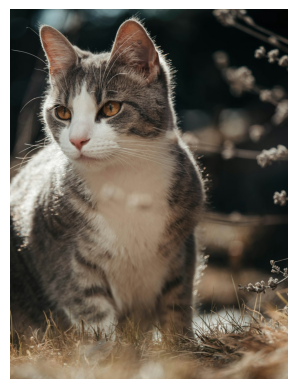

Predicted Class: cat


In [2]:
import cv2
import numpy as np
import os
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set dataset path
dataset_path = "E:/murugesan/Downloads/small"
classes = sorted(os.listdir(dataset_path)) 

# Feature extraction functions
def extract_sift(image):
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(image, None)
    return descriptors.flatten()[:128] if descriptors is not None else np.zeros(128)

def extract_hog(image):
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9, visualize=True)
    return features

def extract_gloh(image):
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(image, None)
    return np.var(descriptors, axis=0) if descriptors is not None else np.zeros(128)

# Load dataset and extract features
X, y = [], []
for label, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (128, 128))

        # Extract features
        features = np.hstack([extract_sift(image), extract_hog(image), extract_gloh(image)])
        X.append(features)
        y.append(label)

# Convert to NumPy arrays
X, y = np.array(X), np.array(y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Test accuracy
y_pred = clf.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Function to classify new images
def classify_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))
    features = np.hstack([extract_sift(image), extract_hog(image), extract_gloh(image)]).reshape(1, -1)
    features = scaler.transform(features)
    pred_label = clf.predict(features)[0]
    print(f"Predicted Class: {classes[pred_label]}")

# Display and classify an image
image_path = "E:/murugesan/Downloads/df.jfif"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')
plt.show()
classify_image(image_path)

Good Matches: 795


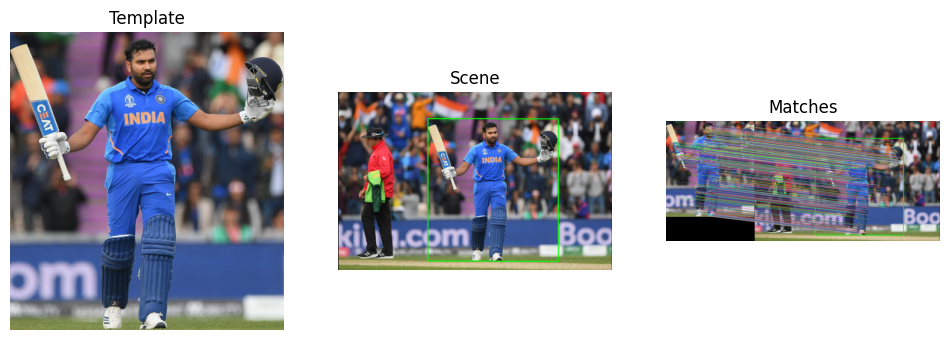

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
scene_path = "E:/murugesan/Downloads/cri.png"
template_path = "E:/murugesan/Downloads/cric.png"

scene = cv2.imread(scene_path)
template = cv2.imread(template_path)
gray_scene = cv2.cvtColor(scene, cv2.COLOR_BGR2GRAY)
gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

# SIFT & FLANN initialization
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray_template, None)
kp2, des2 = sift.detectAndCompute(gray_scene, None)
flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))

# Find matches & apply Lowe's ratio test
matches = flann.knnMatch(np.float32(des1), np.float32(des2), k=2)
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

print(f"Good Matches: {len(good_matches)}")

# Homography if enough matches
if len(good_matches) >= 3:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    if M is not None:
        h, w = gray_template.shape
        box = cv2.perspectiveTransform(np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2), M)
        scene = cv2.polylines(scene, [np.int32(box)], True, (0, 255, 0), 3)

# Draw matches
matches_img = cv2.drawMatches(template, kp1, scene, kp2, good_matches, None, flags=2)

# Display results
plt.figure(figsize=(12, 6))
for i, (title, img) in enumerate([("Template", template), ("Scene", scene), ("Matches", matches_img)]):
    plt.subplot(1, 3, i + 1), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title(title), plt.axis('off')
plt.show()
